In [1]:
import torch
import torch.nn as nn
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

import poisevae
random.seed(30)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

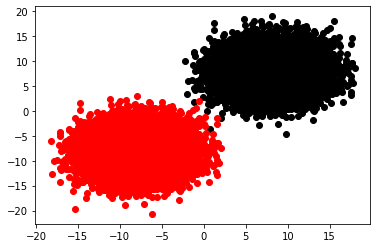

In [2]:
## Transforming data to a higher dimension
"""
inp_data= samplesx1
fun_A   = 1xdim_exp
data    = samplesxdim_exp   (data = inp_dataxfun_A)
"""
dim_exp = 2
fun_A1 = torch.tensor([1, 1])
fun_A2 = torch.tensor([1,-1])
N = 10000
data0 = torch.randn(N, 2) * 3
data1 = data0 + torch.tensor([8, 8])
data2 = data0 - torch.tensor([8, 8])
x1_cord = data1[:,0]
y1_cord = data1[:,1]
x2_cord = data2[:,0]
y2_cord = data2[:,1]
plt.plot(x1_cord,y1_cord, 'o', color='black')
plt.plot(x2_cord,y2_cord, 'o', color='red')
plt.show()

In [3]:
batch_size = 256
train_loader_set1 = DataLoader(
    data1[0:int(0.8*N),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*N):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*N),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*N):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [4]:
class Enc(nn.Module): # Linear
    def __init__(self, dim_exp):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(dim_exp, 8), 
                                 nn.LeakyReLU(inplace=True))
        self.nu1 = nn.Linear(8, 2)
        self.log_nu2 = nn.Linear(8, 2)
    def forward(self, x):
        x = self.enc(x)
        return self.nu1(x), self.log_nu2(x)
    
class Dec(nn.Module): 
    def __init__(self, dim_exp):
        super().__init__()
        self.dec = nn.Sequential(nn.Linear(2, 8), 
                                 nn.LeakyReLU(inplace=True),
                                 nn.Linear(8, dim_exp))
    def forward(self, z):
        return self.dec(z), torch.tensor(1).to(z.device)

In [5]:
enc1 = Enc(dim_exp).to(device)
dec1 = Dec(dim_exp).to(device)
enc2 = Enc(dim_exp).to(device)
dec2 = Dec(dim_exp).to(device)
vae = poisevae.POISEVAE([enc1, enc2], [dec1, dec2], likelihoods=[Normal, Normal], n_IW_sample=10,
                        latent_dims=[2, 2], batch_size=batch_size, fix_t=True).to(device)

In [6]:
for i in vae.named_parameters():
    print(i[0])

g11
g22_hat
g12_hat
g21_hat
encoders.0.enc.0.weight
encoders.0.enc.0.bias
encoders.0.nu1.weight
encoders.0.nu1.bias
encoders.0.log_nu2.weight
encoders.0.log_nu2.bias
encoders.1.enc.0.weight
encoders.1.enc.0.bias
encoders.1.nu1.weight
encoders.1.nu1.bias
encoders.1.log_nu2.weight
encoders.1.log_nu2.bias
decoders.0.dec.0.weight
decoders.0.dec.0.bias
decoders.0.dec.2.weight
decoders.0.dec.2.bias
decoders.1.dec.0.weight
decoders.1.dec.0.bias
decoders.1.dec.2.weight
decoders.1.dec.2.bias
proposal.0.enc.0.weight
proposal.0.enc.0.bias
proposal.0.nu1.weight
proposal.0.nu1.bias
proposal.0.log_nu2.weight
proposal.0.log_nu2.bias
proposal.1.enc.0.weight
proposal.1.enc.0.bias
proposal.1.nu1.weight
proposal.1.nu1.bias
proposal.1.log_nu2.weight
proposal.1.log_nu2.bias


In [7]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [8]:
res = {'epoch': [], 'KL': [], 'rec1': [], 'rec2': [], 'total': [], 'type': []}
for epoch in tqdm(range(100)):
    vae.train()
    for data1,data2 in zip(train_loader_set1, train_loader_set2):
        data = data1.to(device), data2.to(device)
        optimizer.zero_grad()
        results = vae(data)
        results['total_loss'].backward()
        optimizer.step()
        res['epoch'].append(epoch+1)
        res['KL'].append(results['KL_loss'].item())
        res['rec1'].append(results['rec_losses'][0].item())
        res['rec2'].append(results['rec_losses'][1].item())
        res['total'].append(results['total_loss'].item())
        res['type'].append('train')
    with torch.no_grad():
        for data1,data2 in zip(test_loader_set1, test_loader_set2):
            data = data1.to(device), data2.to(device)
            results = vae(data)
            res['epoch'].append(epoch+1)
            res['KL'].append(results['KL_loss'].item())
            res['rec1'].append(results['rec_losses'][0].item())
            res['rec2'].append(results['rec_losses'][1].item())
            res['total'].append(results['total_loss'].item())
            res['type'].append('eval')

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


In [9]:
res = pd.DataFrame(res)

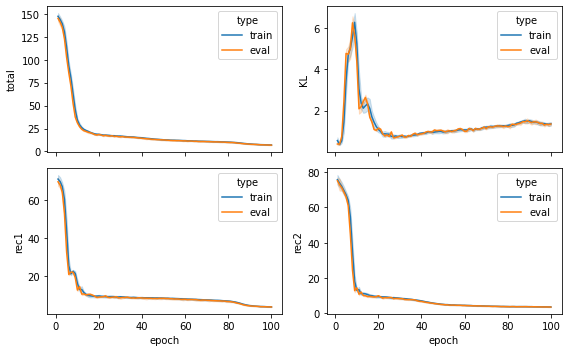

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5), sharex='all')
sns.lineplot(data=res, x='epoch', y='total', hue='type', ax=ax[0, 0], ci='sd')
sns.lineplot(data=res, x='epoch', y='KL', hue='type', ax=ax[0, 1], ci='sd')
sns.lineplot(data=res, x='epoch', y='rec1', hue='type', ax=ax[1, 0], ci='sd')
sns.lineplot(data=res, x='epoch', y='rec2', hue='type', ax=ax[1, 1], ci='sd')
fig.tight_layout()

In [11]:
with torch.no_grad():
    for data1,data2 in zip(test_loader_set1, test_loader_set2):
        data = data1.to(device), data2.to(device)
        results = vae(data)
        break
fetch_np_array = lambda x, f=lambda x: x: torch.stack([f(x[0]), f(x[1])], dim=0).detach().cpu().numpy()
data = fetch_np_array(data)
rec = fetch_np_array(results['x_rec'], lambda x: x.loc)
rec_reshape = fetch_np_array(results['x_rec'], lambda x: x.loc.view(-1, 2))
nu1 = fetch_np_array(results['nu1'])
nu2 = fetch_np_array(results['nu2'])
z = fetch_np_array(results['z'])
w = results['weights'].cpu().detach().numpy().squeeze()

In [12]:
def plot_result(data, res, w):
    fig, ax = plt.subplots(2, sharex='all', sharey='all')
    ax[0].plot(*data[0].T, 'o', color='C0', label='true set1', markersize=3)
    ax[0].plot(*data[1].T, 'o', color='C1', label='true set2', markersize=3)
    ax[0].legend()
    
    w = (w - w.min(axis=1)[:, None]) / (w.max(axis=1) - w.min(axis=1))[:, None]
    for n in range(res.shape[1]):
        for i in range(w.shape[1]):
            ax[1].plot(*res[0, n, i].T, 'o', color='C0', alpha=w[n, i], markersize=3)
            ax[1].plot(*res[1, n, i].T, 'o', color='C1', alpha=w[n, i], markersize=3)
    mini = min(data[0].min(), data[1].min())
    maxi = max(data[0].max(), data[1].max())
    ax[1].set_xlim([mini, maxi])
    ax[1].set_ylim([mini, maxi])
    return fig, ax

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

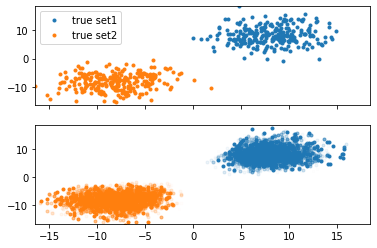

In [13]:
# With weighting
plot_result(data, rec, w)

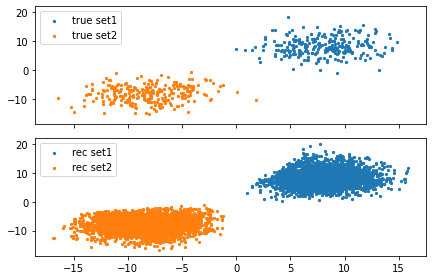

In [14]:
# Without weighting
fig, ax = plt.subplots(2, sharex='all', sharey='all')
for i, (d, l) in enumerate(zip((data, rec_reshape), ('true', 'rec'))):
    ax[i].scatter(*d[0].T, s=5, color='C0', label=l + ' set1')
    ax[i].scatter(*d[1].T, s=5, color='C1', label=l + ' set2')
    ax[i].legend()
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, sharex='all', sharey='all')
for k in range(3):
    n = np.random.randint(0, batch_size)
    ax[0].plot(*data[0, n:n+1].T, 's', color='C%d'%k)
    ax[0].plot(*data[1, n:n+1].T, 'o', color='C%d'%k)
    for i in range(w.shape[1]):
        ax[1].plot(*rec[0, n:n+1, i].T, 's', color='C%d'%k, alpha=w[n, i])
        ax[1].plot(*rec[1, n:n+1, i].T, 'o', color='C%d'%k, alpha=w[n, i])
fig.tight_layout()

In [ ]:
with torch.no_grad():
    results = vae.generate(50)
fetch_np_array = lambda x, f=lambda x: x: torch.stack([f(x[0]), f(x[1])], dim=0).detach().cpu().numpy()
gen = fetch_np_array(results['x_rec'], lambda x: x.loc)
gen_reshape = fetch_np_array(results['x_rec'], lambda x: x.loc.view(-1, 2))
z_gen = fetch_np_array(results['z'])
w = results['weights'].cpu().detach().numpy()

In [ ]:
# With weighting
plot_result(data, gen, w)

In [ ]:
# Without weighting
fig, ax = plt.subplots(2, sharex='all', sharey='all')
ax[0].scatter(*data[0].T, s=5, color='C0', label='true set1')
ax[0].scatter(*data[1].T, s=5, color='C1', label='true set2')
ax[0].legend()
for i in range(w.shape[0]):
    ax[1].scatter(*gen[0, :, i].T, s=5, color='C0')#, alpha=w[i])
    ax[1].scatter(*gen[1, :, i].T, s=5, color='C1')#, alpha=w[i])
fig.tight_layout()